In [39]:
%pip install BeautifulSoup

  Using cached BeautifulSoup-3.2.2.tar.gz (32 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      Traceback (most recent call last):
        File "c:\Users\H.T\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "c:\Users\H.T\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\H.T\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 118, in get_requires_for_build_wheel
          return hook(config_settings)
                 ^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\H.T\AppData\Local\Temp\pip-build-env-8h2fimd8\overlay\

In [2]:

# %pip install requests
# %pip install beautifulsoup4

import os
import json
import time
import random
import zipfile
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

# Class Explanation: `NewsScraper`

## Overview
The `NewsScraper` class is designed for scraping news articles from three different Urdu news websites: Geo, Jang, and Express. The class has methods that cater to each site's unique structure and requirements. Below, we will go through the class and its methods, detailing what each function does, the input it takes, and the output it returns.

## Class Definition

```python
class NewsScraper:
    def __init__(self, id_=0):
        self.id = id_
```


## Method 1: `get_express_articles`

### Description
Scrapes news articles from the Express website across categories like saqafat (entertainment), business, sports, science-technology, and world. The method navigates through multiple pages for each category to gather a more extensive dataset.

### Input
- **`max_pages`**: The number of pages to scrape for each category (default is 7).

### Process
- Iterates over each category and page.
- Requests each category page and finds article cards within `<ul class='tedit-shortnews listing-page'>`.
- Extracts the article's headline, link, and content by navigating through `<div class='horiz-news3-caption'>` and `<span class='story-text'>`.

### Output
- **Returns**: A tuple of:
  - A Pandas DataFrame containing columns: `id`, `title`, and `link`).
  - A dictionary `express_contents` where the key is the article ID and the value is the article content.

### Data Structure
- Article cards are identified by `<li>` tags.
- Content is structured within `<span class='story-text'>` and `<p>` tags.



In [20]:
class NewsScraper:
    def __init__(self,id_=0):
        self.id = id_


  # write functions to scrape from other websites
    def get_samaa_articles(self):
        samaa_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://urdu.samaa.tv'
        categories = ['lifestyle', 'money' , 'sports', 'tech' ,'global']
        headers = {
            "referer": "https://urdu.samaa.tv",
            "sec-ch-ua": '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
            "sec-ch-ua-mobile": "?1",
            "sec-ch-ua-platform": '"Android"',
            "sec-fetch-dest": "document",
            "sec-fetch-mode": "navigate",
            "sec-fetch-site": "same-origin",
            "sec-fetch-user": "?1",
            "upgrade-insecure-requests": "1",
            "user-agent": "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Mobile Safari/537.36"
        }
        # Iterating over the specified number of pages
        for category in categories:
            print(f"Scraping page of category '{category}'...")
            url= f"{base_url}/{category}/"
            
            response = requests.get(url, headers=headers)

            response.raise_for_status()

            soup = BeautifulSoup(response.text, "html.parser")
            
            cards = soup.find_all('article', class_='story-article')

            for card in cards:
                try:
                    headline= card.find('h3').get_text(strip=True)
                    link = card.find('a')['href']
                    
                    # print(f"Headline '{headline}'...")
                    # print(f"Link: {link}")

                    article_response = requests.get(link, headers=headers)
                    article_response.raise_for_status()
                    
                    content_soup = BeautifulSoup(article_response.text, "html.parser")
                    
                    paras = content_soup.find('div', class_='share-bar').find_all('p')
                    
                    combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                    )

                
                    # print(f"Content: {combined_text[:500]}...")
                    
                    samaa_df['id'].append(self.id)
                    samaa_df['title'].append(headline)
                    samaa_df['link'].append(link)
                    samaa_df['gold_label'].append(category)
                    samaa_df['content'].append(combined_text)

                    self.id += 1

                    
                except Exception as e:
                    print(f"\t--> Failed to scrape an article on page of '{category}': {e}")

        return pd.DataFrame(samaa_df)
            
    def get_jang_articles(self):
        jang_fd = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://jang.com.pk'
        categories = ['entertainment', 'business', 'sports', 'science-technology', 'world']
        
        # Iterating over the specified number of pages
        for category in categories:
            print(f"Scraping page of category '{category}'...")
            url = f"{base_url}/category/latest-news/{category}"
            response = requests.get(url)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, "html.parser")
            cards = soup.find_all('div', class_='main-heading')

            for card in cards:
                try:
                    # Article Title
                    headline = card.find('h2').get_text(strip=True)
                    # Article link
                    link = card.find('a')['href']

                    # # Requesting the content from each article's link
                    article_response = requests.get(link)
                    article_response.raise_for_status()
                    content_soup = BeautifulSoup(article_response.text, "html.parser")

                    # # Content arranged in paras inside <div> tags
                    paras = content_soup.find('div', class_='detail_view_content').find_all('p')
                    combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                    )
                    # # Storing data
                    jang_fd['id'].append(self.id)
                    jang_fd['title'].append(headline)
                    jang_fd['link'].append(link)
                    jang_fd['gold_label'].append(category)
                    jang_fd['content'].append(combined_text)

                    # Increment ID
                    self.id += 1

                except Exception as e:
                    print(f"\t--> Failed to scrape an article): {e}")
        
        return pd.DataFrame(jang_fd)

    def get_geo_articles(self):
        geo_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://urdu.geo.tv'
        categories = ['entertainment', 'business', 'sports', 'science-technology', 'world']

        # Iterating over the specified number of pages
        for category in categories:
            print(f"Scraping page of category '{category}'...")
            url = f"{base_url}/category/{category}"
            response = requests.get(url)
            
            # print("Here")
            # print(response)

            response.raise_for_status()
            soup = BeautifulSoup(response.text, "html.parser")
            cards = soup.find_all('div', class_="col-xs-6 col-sm-6 col-lg-6 col-md-6 singleBlock")
            # print(cards)

            for card in cards:
                try:
                    # Article Title
                    headline = card.find('h2', {'data-vr-headline': True}).get_text(strip=True)
                    # print("Headline: ",headline)

            #         # Article link
                    link = card.find('a')['href']
                    # print("Link: ",link)

            #         # Requesting the content from each article's link
                    article_response = requests.get(link)
                    article_response.raise_for_status()
                    content_soup = BeautifulSoup(article_response.text, "html.parser")
            #         # Content arranged in paras inside <div> tags
                    paras = content_soup.find('div', class_='content-area').find_all('p')

                    combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                    )
                    # print("Content: ",combined_text)

            #         # Storing data
                    geo_df['id'].append(self.id)
                    geo_df['title'].append(headline)
                    geo_df['link'].append(link)
                    geo_df['gold_label'].append(category)
                    geo_df['content'].append(combined_text)

            #         # Increment ID
                    self.id += 1

                except Exception as e:
                    print(f"\t--> Failed to scrape an article on page of '{category}': {e}")

    
        return pd.DataFrame(geo_df)

    def get_dawn_articles(self, dates=3):
        dawn_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://www.dawnnews.tv'
        categories = ['entertainment', 'business', 'sport', 'tech', 'world']

        # Iterating over the specified number of pages
        for category in categories:
            for date in range(1+15, dates + 16):
                print(f"Scraping date-page 2024-11-{date} of category '{category}'...")

                url = f"{base_url}/{category}/2024-11-{date}"
                headers = {
                    "referer": base_url,
                    "sec-ch-ua": '"Google Chrome";v="131", "Chromium";v="131", "Not_A Brand";v="24"',
                    "sec-ch-ua-mobile": "?1",
                    "sec-ch-ua-platform": '"Android"',
                    "sec-fetch-dest": "document",
                    "sec-fetch-mode": "navigate",
                    "sec-fetch-site": "same-origin",
                    "sec-fetch-user": "?1",
                    "upgrade-insecure-requests": "1",
                    "user-agent": "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Mobile Safari/537.36"
                }
                response = requests.get(url, headers=headers)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find_all('article', class_='story')

                for card in cards:
                    try:
                        # Article Title
                        headline = card.find('h2').get_text(strip=True)
                        # print(f"Headline: {headline}")

                        # Article link
                        link = card.find('a', class_="story__link")['href']
                        # print(f"Link: {link}")

                        article_response = requests.get(link)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")


                        # Content arranged in paras inside <div> tags
                        paras = content_soup.find('div', class_="story__content").find_all('p')
                        
                        combined_text = " ".join(
                            p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                            for p in paras if p.get_text(strip=True)
                        )
                        # print(f"Content: {combined_text[:500]}...")

                        # Storing data
                        dawn_df['id'].append(self.id)
                        dawn_df['title'].append(headline)
                        dawn_df['link'].append(link)
                        dawn_df['gold_label'].append(category)
                        dawn_df['content'].append(combined_text)

                        # Increment ID
                        self.id += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on date-page {date} of '{category}': {e}")

        return pd.DataFrame(dawn_df)
    
    def get_express_articles(self, max_pages=7):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://www.express.pk'
        categories = ['saqafat', 'business', 'sports', 'science', 'world']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1, max_pages + 1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}/?page={page}"
                response = requests.get(url)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find('ul', class_='tedit-shortnews listing-page').find_all('li')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='horiz-news3-caption')

                        # Article Title
                        headline = div.find('a').get_text(strip=True).replace('\xa0', ' ')

                        # Article link
                        link = div.find('a')['href']

                        # Requesting the content from each article's link
                        article_response = requests.get(link)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")


                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('span',class_='story-text').find_all('p')

                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('saqafat','entertainment').replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')

        return pd.DataFrame(express_df)

In [21]:
scraper = NewsScraper()

In [22]:
# Ensure that the cell with imports and scraper object definition is executed before running this cell
# express_df = scraper.get_express_articles()
dawn_df = scraper.get_dawn_articles()
# geo_df = scraper.get_geo_articles()
# jang_df = scraper.get_jang_articles()
# samaa_df = scraper.get_samaa_articles()

Scraping date-page 2024-11-16 of category 'entertainment'...
	--> Failed to scrape an article on date-page 16 of 'entertainment': 403 Client Error: Forbidden for url: https://www.dawnnews.tv/news/1247030/
	--> Failed to scrape an article on date-page 16 of 'entertainment': 403 Client Error: Forbidden for url: https://www.dawnnews.tv/news/1247018/
	--> Failed to scrape an article on date-page 16 of 'entertainment': 403 Client Error: Forbidden for url: https://www.dawnnews.tv/news/1246962/
	--> Failed to scrape an article on date-page 16 of 'entertainment': 403 Client Error: Forbidden for url: https://www.dawnnews.tv/news/1246957/
	--> Failed to scrape an article on date-page 16 of 'entertainment': 403 Client Error: Forbidden for url: https://www.dawnnews.tv/news/1246884/
	--> Failed to scrape an article on date-page 16 of 'entertainment': 403 Client Error: Forbidden for url: https://www.dawnnews.tv/news/1246877/
	--> Failed to scrape an article on date-page 16 of 'entertainment': 403 Cl

# Output
- Save a combined csv of all 3 sites.

In [17]:

# geo_df.to_csv('geo_articles.csv', index=False)
# jang_df.to_csv('jang_articles.csv', index=False)
# dawn_df.to_csv('dawn_articles.csv', index=False)
# express_df.to_csv('express_articles.csv', index=False)
# samaa_df.to_csv('samaa_articles.csv', index=False)

# Load all the CSVs
combined_df = pd.read_csv('combined_articles.csv')
# Shuffle the rows of the combined dataframe
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Save the combined dataframe to a new CSV file
combined_df.to_csv('combined_articles.csv', index=False)

```markdown
# Data Cleaning and Exploratory Data Analysis (EDA)

## Data Cleaning Techniques

### 1. Handling Missing Values
- **Identify Missing Values**: Check for any missing values in the dataset.
- **Remove or Impute Missing Values**: Depending on the context, either remove rows with missing values or impute them with appropriate values (e.g., mean, median, mode).

### 2. Removing Alphabets
- **Remove Non-Urdu Characters**: Since the dataset is in Urdu, remove any non-Urdu characters (e.g., English alphabets, special characters).

### 3. Handling Outliers
- **Identify Outliers**: Use statistical methods (e.g., IQR, Z-score) to identify outliers in numerical columns.
- **Remove or Cap Outliers**: Depending on the context, either remove outliers or cap them to a certain threshold.

### 4. Data Normalization
- **Normalize Text Data**: Convert text data to a consistent format (e.g., lowercase, remove extra spaces).

## Exploratory Data Analysis (EDA)

### 1. Data Distribution
- **Visualize Data Distribution**: Use histograms, box plots, and other visualizations to understand the distribution of numerical columns.
- **Analyze Text Data**: Use word clouds, frequency distributions, and other text analysis techniques to understand the distribution of text data.

### 2. Data Patterns
- **Identify Patterns**: Look for patterns and correlations in the data (e.g., correlation matrix, scatter plots).
- **Analyze Categories**: Analyze the distribution of categorical columns (e.g., gold_label).

## Implementation

```python


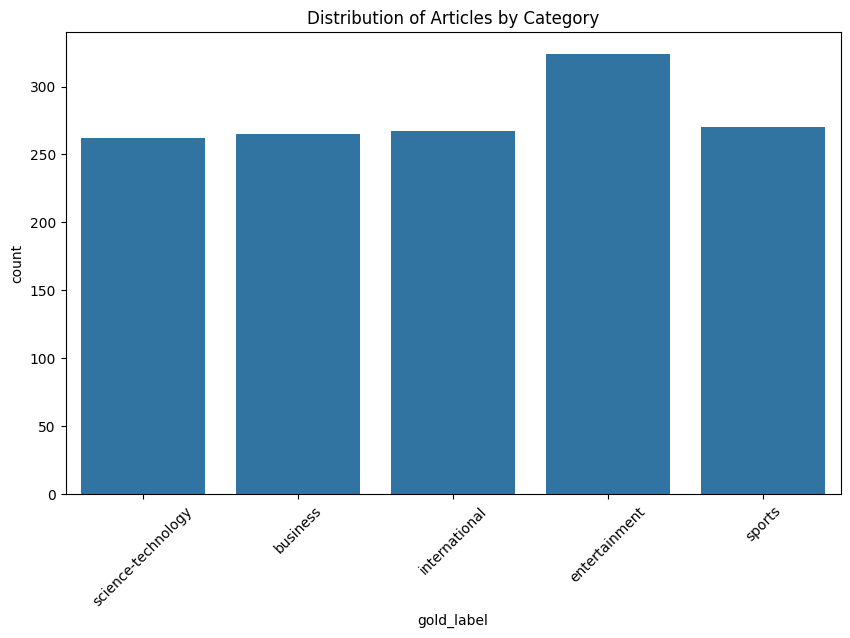

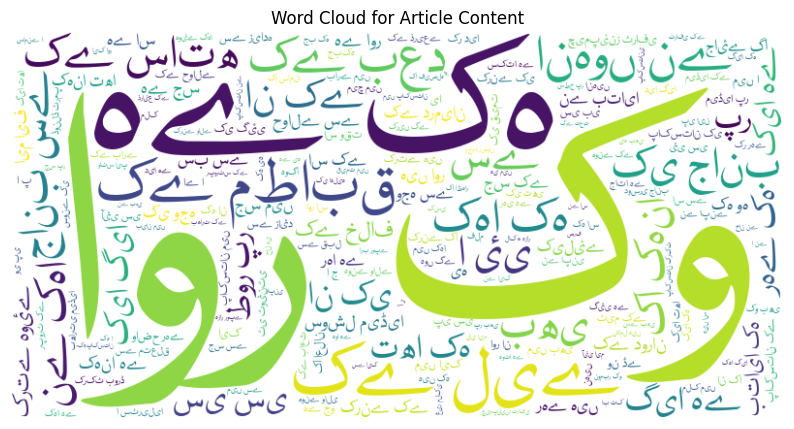

In [ ]:


# Load the stopwords file
# Access all txt files in /urdu and store the words inside those in stopwords of urdu
stopwords = set()
urdu_stopwords_path = 'urdu'

for filename in os.listdir(urdu_stopwords_path):
    if filename.endswith('.txt'):
        with open(os.path.join(urdu_stopwords_path, filename), 'r', encoding='utf-8') as file:
            for line in file:
                stopwords.update(line.strip().split())

print(f"Total stopwords loaded: {len(stopwords)}")

# Remove commas from stopwords
stopwords = {word.replace('"', '') for word in stopwords}
stopwords = {word.replace('\'', '') for word in stopwords}

print("Sample stopwords:", stopwords)


# Load the combined CSV
combined_df = pd.read_csv('combined_articles.csv')

combined_df.dropna(subset=['content'], inplace=True)


def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

combined_df['content'] = combined_df['content'].apply(remove_stopwords)
combined_df['title'] = combined_df['title'].apply(remove_stopwords)

print("Stopwords removed from the content and title columns.")

def remove_non_urdu(text):
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'[^\u0600-\u06FF\s,]', '', text)
    text = re.sub(r'،', '', text)
    text = re.sub(r'؛', '', text)
    text = re.sub(r'\d', '', text)
    text = re.sub(r'؟', ' ', text)

    return text

combined_df['content'] = combined_df['content'].apply(remove_non_urdu)
combined_df['title'] = combined_df['title'].apply(remove_non_urdu)

# Data Normalization
combined_df['content'] = combined_df['content'].str.strip()
combined_df['title'] = combined_df['title'].str.strip()

# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties


# Data Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='gold_label')
plt.title('Distribution of Articles by Category')
plt.xticks(rotation=45)
plt.show()


font_path = r'D:\LUMS\Junior Fall 2024\CS438 ML\Group Project\GroupNo_Project\Nafees Regular.ttf'
urdu_font = FontProperties(fname=font_path)


text = ' '.join((combined_df['content'] + combined_df['title']).dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Article Content')
plt.show()

# Save the cleaned dataframe
combined_df.to_csv('cleaned_combined_articles.csv', index=False)
